In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

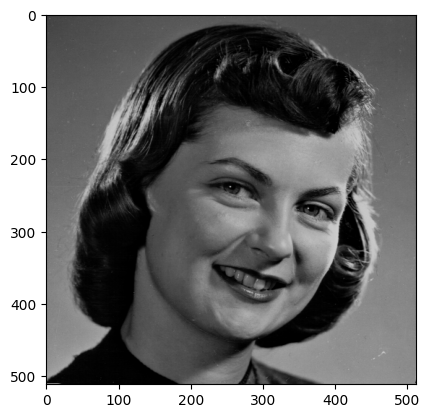

In [8]:
img = cv2.imread("GirlFace.png")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# Part 1

## 1.1 Histogram
- Download the Girl Face image 
- Plot a histogram of the grey levels it contains. (Try plotting a histogram of another grey scale image and comparing the difference)
##### 5 points

## 1.2 Threshold 
- Write a short program to threshold the image and try to identify a good threshold by trial and
error. 
- Create a ground truth segmentation. 
##### 15 points

## 1.3 ROC Curve
- Use your ground truth segmentation to plot an ROC curve for your thresholding algorithm. 
    
    `What threshold does the ROC curve suggest?`
        Note: You may have to implement an algorithm to find the point closest to a desired Operating Point. 
    `How does it compare to your trial and error estimate?`
##### 30 points

# Part 2

## 2.1 Region growing algorithm 
- Implement a region growing algorithm 
- Compare its performance at segmenting the face in the image above with the performance of the thresholding algorithm.
- Show the seeds you chose.
##### (25 points)

## 2.2 Mean-shift algorithm
- Implement the mean-shift algorithm.
- Show the results that you achieve for different values of the 'radius' parameter.
##### 25 points

# Detailed report
- Point out your process, thoughts and outcomes.